# Information Extraction from Financial Documents using Named Entity Recognition

Information extraction is a structured prediction task: it takes in a sequence of tokens and returns structured data, such a identifying specific spans within a piece of text, labeling individual tokens, or identifying the relationships between tokens or spans.

Information extraction is generally useful for a different set of uses than classic text analysis methods such as named entity recognition, topic modeling, etc. In many document-based models, the text itself is of interest: what writers are talking about, how topics co-occur with each other, etc. In many of the use cases of information extraction, the text is simply a convienient data source that can be mined for data that is useful in a downstream analysis. In other words, rather than text itself being the object of interest, text in an information extraction framework is often the medium through which data is reported.

In [1]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading Documents

In [2]:
# Load data
data_path = "/kaggle/input/3-document-cleaning/cleaned-docs.csv"
df_docs = pd.read_csv(data_path)

# Convert lists represented as strings to lists within the dataframe
df_docs['HSentences'] = df_docs['HSentences'].apply(ast.literal_eval)
df_docs['MSentences'] = df_docs['MSentences'].apply(ast.literal_eval)

In [3]:
df_docs.head()

,Report Name,Bank Name,Report Date,Page ID,Page Text,MSentences,HSentences
0,fx_insight_e_16_janvier_2023,citi,16-1-2023,0,\n Citi Global Wealth Investments \n FX Snaps...,[citi global wealth invest fx snapshot major c...,[ Citi Global Wealth Investments FX Snapshot M...
1,fx_insight_e_16_janvier_2023,citi,16-1-2023,3,\n Important Disclosure \n “Citi analysts” ref...,[import disclosur citi analyst refer invest pr...,[ Important Disclosure Citi analysts refers to...
2,exemple_analyse_macro_economique_goldman_sachs,goldman_sachs,NaN,0,\n Fixed Income \n MUSINGS \n FIXED INCOME Go...,[fix incom muse fix incom goldman sach asset m...,[ Fixed Income MUSINGS FIXED INCOME Goldman Sa...
3,exemple_analyse_macro_economique_goldman_sachs,goldman_sachs,NaN,1,\n Fixed Income \n MUSINGS \n Goldman Sachs As...,[fix incom muse goldman sach asset manag fix i...,[ Fixed Income MUSINGS Goldman Sachs Asset Man...
4,exemple_analyse_macro_economique_goldman_sachs,goldman_sachs,NaN,2,\n MUSINGS \n FIXED INCOME Goldman Sachs Asse...,[muse fix incom goldman sach asset manag centr...,[ MUSINGS FIXED INCOME Goldman Sachs Asset Man...


In [4]:
# Total number of documents 
df_docs.shape

(395, 7)

In [5]:
# Number of documents by org
doc_by_org_counts = df_docs.groupby('Bank Name')['Report Name'].nunique().reset_index()
doc_by_org_counts

,Bank Name,Report Name
0,bnp_parisba,1
1,citi,11
2,goldman_sachs,5
3,jpmorgan,2
4,kkr,1


In [6]:
# Number of total pages by org
pages_by_org_counts = df_docs.groupby('Bank Name')['Page ID'].count().reset_index()
pages_by_org_counts

,Bank Name,Page ID
0,bnp_parisba,30
1,citi,62
2,goldman_sachs,146
3,jpmorgan,85
4,kkr,72


In [7]:
from itertools import chain

def get_document(document, by="words", col="MSentences", paginated=False):
    # Get the sentences of all pages
    pages_sentences = document[col].tolist()   
    
    if by == "words":
        pages_words = []
        for page_sentences in pages_sentences:
            page_words = []
            for sentence in page_sentences:
                sent_tokens = word_tokenize(sentence)
                page_words.append(sent_tokens)
            
            pages_words.append(list(chain.from_iterable(page_words)))
        results = pages_words
        
    elif by == "sentences":
        results = pages_sentences
        
    elif by == "document":
        results = [ " ".join(page_sentences).strip() for page_sentences in pages_sentences ]
        if not paginated: 
            return " ".join(results).strip()
            
    if paginated:
        return results
    return list(chain.from_iterable(results))

In [8]:
report_name = "fx_insight_e_15_mai_2023"
document = df_docs[df_docs['Report Name'] == report_name].sort_values(by='Page ID')
print("The document", report_name, "has", len(document), "pages.")

The document fx_insight_e_15_mai_2023 has 7 pages.


In [9]:
# Get the first 10 words of a page of the document
page_id = 0
print(get_document(document, by="words", col="MSentences", paginated=True)[page_id][:10])

# Get the first 3 sentences of a page of the document
print(get_document(document, by="sentences", col="MSentences", paginated=True)[page_id][:3])

# Get a small chunk from the whole document
print(get_document(document, by="document", col="MSentences", paginated=False)[:100])

['invest', 'product', 'bank', 'deposit', 'govern', 'insur', 'bank', 'guarante', 'lose', 'valu']
['invest product bank deposit', 'govern insur', 'bank guarante']
invest product bank deposit govern insur bank guarante lose valu major currenc perform sourc bloombe


In [10]:
print(get_document(document, by="document", col="HSentences", paginated=True)[4])

Safe-haven Currencies CHF Citi views & strategy Bias/ Forecasts/ Key levels Citi FX outlook Room for more short-term hawkishness - domestic factors enable an incrementally hawkish SNB, which should keep CHF supported. SNBs conditional inflation forecast would suggest the need for additional hikes, and the improvement in leading indicators creates room for a hawkish surprise. Previously USDCHF: 0 3mths: 0.90 USDCHF: 6 12mths: 0.87 USDCHF: LT: 0.85 Currently (as of Apr): USDCHF: 0 3mths: 0.87 USDCHF: 6 12mths: 0.86 USDCHF: LT: 0.85 6-12mths: Bullish CHF vs USD, moderately bearish vs EUR JPY Citi views & strategy Bias/ Forecasts/ Key levels Citi FX outlook BoJ YCC shift remains in play. Citi analysts base case is for shortening of the target duration from 10y to 5y or 3y in June meeting (after final outcome of spring wage negotiations). For US, as more hikes are priced, total cycle cuts are likely to deepen. Even in the scenario of a hawkish Fed, we think it may be hard for US duration to

## NER with spaCy

In [11]:
%%capture 
!pip install --upgrade spacy
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

### NER for a Sample Document 

In [12]:
ner_report_name = 'goldman_sachs_global_outlook'
ner_document = df_docs[df_docs['Report Name'] == ner_report_name].sort_values(by='Page ID')
ner_pages = get_document(ner_document, by="document", col="HSentences", paginated=True)

In [13]:
len(ner_pages)

24

In [14]:
ner_pages[0]

'Global growth slowed through 2022 on a diminishing reopening boost, fiscal and n monetary tightening, Chinas Covid restrictions and property slump, and the Russia-Ukraine war. We expect global growth of just 1.8% in 2023, as US resilience contrasts with a European recession and a bumpy reopening in China. The US should narrowly avoid recession as core PCE inflation slows from 5% n now to 3% in late 2023 with a pp rise in the unemployment rate. To keep growth below potential amidst stronger real income growth, we now see the Fed hiking another 125bp to a peak of 5-5.25%. We do not expect cuts in 2023. How can core inflation fall so much with such a small employment hit? The n reason, we think, is that this cycle is different from prior high-inflation periods. First, post-pandemic labor market overheating showed up not in excessive employment but in unprecedented job openings, which are much less painful to unwind. Second, the disinflationary impact of the recent normalization in supply

In [15]:
%%time 
import spacy
from spacy import displacy
import spacy_transformers
from tqdm import tqdm

# Load the spaCy model for English
nlp = spacy.load("en_core_web_trf")

# Input
docs = list(tqdm(nlp.pipe(ner_pages), total=len(ner_pages)))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

CPU times: user 1min 55s, sys: 25.6 s, total: 2min 20s
Wall time: 1min 19s


In [16]:
entity_types = nlp.pipe_labels["ner"]

for ent in entity_types:
    print(ent,"-",spacy.explain(ent))

CARDINAL - Numerals that do not fall under another type
DATE - Absolute or relative dates or periods
EVENT - Named hurricanes, battles, wars, sports events, etc.
FAC - Buildings, airports, highways, bridges, etc.
GPE - Countries, cities, states
LANGUAGE - Any named language
LAW - Named documents made into laws.
LOC - Non-GPE locations, mountain ranges, bodies of water
MONEY - Monetary values, including unit
NORP - Nationalities or religious or political groups
ORDINAL - "first", "second", etc.
ORG - Companies, agencies, institutions, etc.
PERCENT - Percentage, including "%"
PERSON - People, including fictional
PRODUCT - Objects, vehicles, foods, etc. (not services)
QUANTITY - Measurements, as of weight or distance
TIME - Times smaller than a day
WORK_OF_ART - Titles of books, songs, etc.


#### Entity Visual Extraction

In [17]:
relevant_entity_types = list(set(entity_types) - set(['WORD OF ART', 'ORDINAL']))

for i in range(2):
    print(f"- Page #{i}")
    sent = docs[i]
    if len(sent.ents) > 0:
        displacy.render(sent, style="ent", jupyter=True, options={"ents":relevant_entity_types})
    else:
        print(sent)
        print('No entity found')
    print()

- Page #0



- Page #1


#### Entity Type Frequency

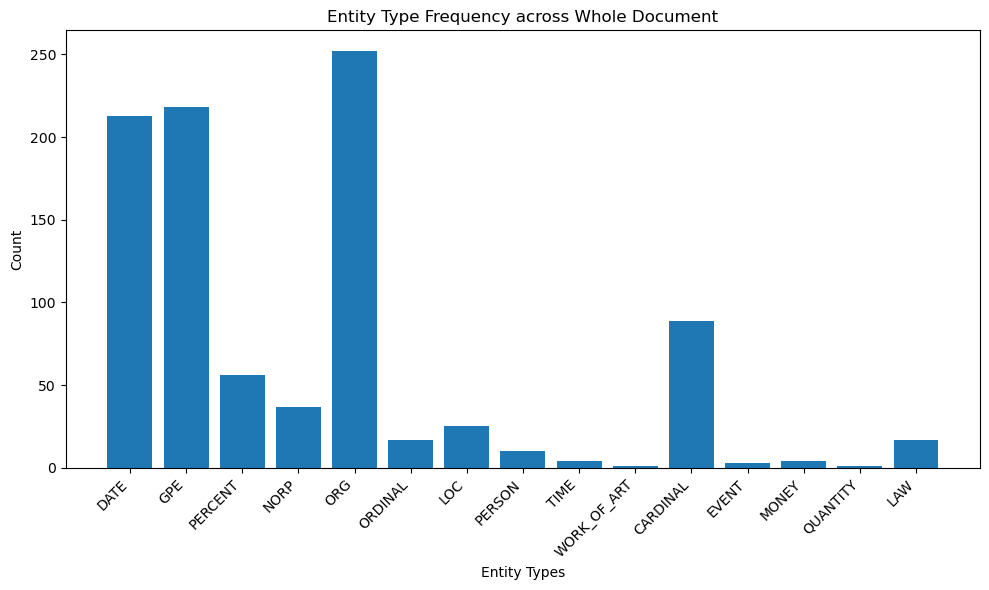

In [18]:
from collections import Counter

# Process documents and extract entities
all_entities = []
for doc in docs:
    entity_types = [ent.label_ for ent in doc.ents]
    all_entities.extend(entity_types)

# Count the occurrences of each entity
entity_counts = Counter(all_entities)

# Extract entity types and their counts
entity_types = list(entity_counts.keys())
entity_type_counts = list(entity_counts.values())

# Create a bar plot of entity distribution
plt.figure(figsize=(10, 6))
plt.bar(entity_types, entity_type_counts)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Entity Types")
plt.ylabel("Count")
plt.title("Entity Type Frequency across Whole Document")
plt.tight_layout()
plt.show()

#### Most Frequent Entities

In [19]:
for entity in ['ORG', 'GPE', 'NORP', 'LOC']:
    print('- Entity Type:', entity)
    all_ents = []
    for d in docs:
        ents = [ent.text for ent in d.ents if ent.label_ == entity]
        all_ents.extend(ents)

    top_common = Counter(all_ents).most_common(10)
    print(top_common)
    print()
    # Create an interactive count plot using Plotly
    entities, counts = zip(*top_common)
    fig = px.bar(x=entities, y=counts, labels={'x': 'Entities', 'y': 'Count'},
                 title=f"Top Frequent Entity for Type '{entity}'")
    fig.update_xaxes(tickangle=-45)
    fig.show()

- Entity Type: ORG
[('Goldman Sachs', 48), ('Goldman Sachs Global Investment Research', 23), ('Haver Analytics', 13), ('Goldman Sachs & Co. LLC', 10), ('Fed', 9), ('Bloomberg', 9), ('ECB', 5), ('GS', 5), ('Goldman Sachs (Asia) L.L.C.', 4), ('Goldman Sachs International', 4)]



- Entity Type: GPE
[('US', 41), ('China', 23), ('UK', 12), ('Brazil', 11), ('Canada', 8), ('Russia', 6), ('Japan', 6), ('Hong Kong', 6), ('Australia', 6), ('India', 5)]



- Entity Type: NORP
[('European', 9), ('Russian', 7), ('Canadian', 5), ('German', 3), ('Chinese', 2), ('Italian', 2), ('Non-YOU.S.', 2), ('Chinas', 1), ('East Asian', 1), ('Asian', 1)]



- Entity Type: LOC
[('Europe', 14), ('Latin America', 3), ('Euro area', 2), ('the European Economic Area', 2), ('Central/Eastern Europe', 1), ('Euro', 1), ('Central and Eastern Europe', 1), ('the Middle Eastwhile', 1)]



#### Entities Co-occuring with X

- Entity US co-occuring with inflation
- Page:  Global growth slowed through 2022 on a diminishing reopening boost, fiscal and n monetary tightening, Chinas Covid restrictions and property slump, and the Russia-Ukraine war. We expect global growth of just 1.8% in 2023, as US resilience contrasts with a European recession and a bumpy reopening in China. The US should narrowly avoid recession as core PCE inflation slows from 5% n now to 3% in late 2023 with a pp rise in the unemployment rate. To keep growth below potential amidst stronger real income growth, we now see the Fed hiking another 125bp to a peak of 5-5.25%. We do not expect cuts in 2023. How can core inflation fall so much with such a small employment hit? The n reason, we think, is that this cycle is different from prior high-inflation periods. First, post-pandemic labor market overheating showed up not in excessive employment but in unprecedented job openings, which are much less painful to unwind. Second, the disinflationa

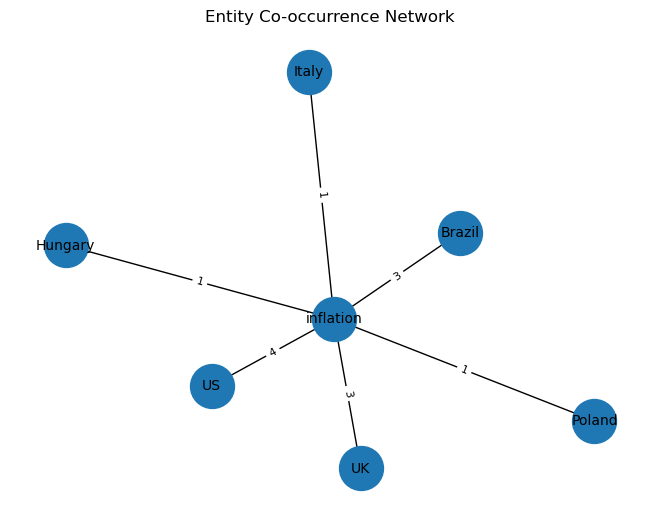

In [20]:
import re
import networkx as nx

x = "inflation"
print_limit, i = 2, 0 # output readability
ent_type = "GPE"
co_occ = []
for d in docs:
    for ent in d.ents:
        if ent.label_ != ent_type:
            continue
        if re.search(x, ent.sent.text):
            if i <= print_limit:
                print('- Entity', ent.text, 'co-occuring with',x)
                print("- Page: ",d)
                print()
                i += 1
            co_occ.append((ent.text, x))


# Count the frequency of entity pairs
entity_pair_counts = Counter(co_occ)

# Create a NetworkX graph
G = nx.Graph()
for pair, freq in entity_pair_counts.items():
    entity1, entity2 = pair
    G.add_edge(entity1, entity2, weight=freq)

# Draw the network graph 
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10)
edge_labels = {(entity1, entity2): f"{freq}" for (entity1, entity2), freq in entity_pair_counts.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Entity Co-occurrence Network")
plt.show()


#### Entities Frequently Co-occuring Together

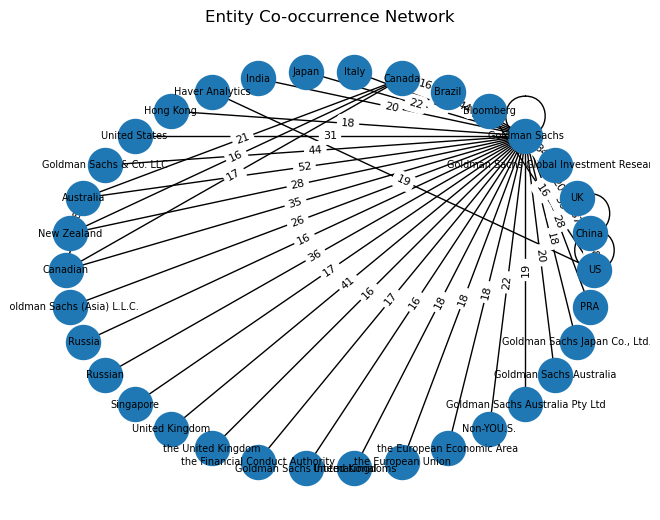

In [21]:
entity_pairs = []
for doc in docs:
    entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'GPE', 'NORP']]
    entity_pairs.extend([(entities[i], entities[j]) for i in range(len(entities)) for j in range(i+1, len(entities))])

entity_pair_counts = Counter(entity_pairs)
threshold_count = 15 

entity_pair_counts = {pair: freq for pair, freq in entity_pair_counts.items() if freq > threshold_count}

G = nx.Graph()
for pair, freq in entity_pair_counts.items():
    entity1, entity2 = pair
    G.add_edge(entity1, entity2, weight=freq)

pos = nx.circular_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=600, font_size=7)
edge_labels = {(entity1, entity2): f"{freq}" for (entity1, entity2), freq in entity_pair_counts.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Entity Co-occurrence Network")
plt.show()


### Extract Entities from all Documents within Dataset

In [22]:
df_docs['Entity'] = ""

for index, row in df_docs.iterrows():
    page_text = " ".join(row['HSentences'])
    doc = nlp(page_text)
    
    page_entities = {ent_type: [] for ent_type in ['ORG', 'GPE', 'NORP', 'LOC', 'DATE']}
    
    for ent in doc.ents:
        if ent.label_ in page_entities:
            page_entities[ent.label_].append(ent.text)
            
    for k, v in page_entities.items():
        page_entities[k] = list(set(v))
        
    df_docs.at[index, 'Entity'] = page_entities

In [23]:
df_docs.head()

,Report Name,Bank Name,Report Date,Page ID,Page Text,MSentences,HSentences,Entity
0,fx_insight_e_16_janvier_2023,citi,16-1-2023,0,\n Citi Global Wealth Investments \n FX Snaps...,[citi global wealth invest fx snapshot major c...,[ Citi Global Wealth Investments FX Snapshot M...,"{'ORG': ['Citi', 'Bloomberg L.P.'], 'GPE': [],..."
1,fx_insight_e_16_janvier_2023,citi,16-1-2023,3,\n Important Disclosure \n “Citi analysts” ref...,[import disclosur citi analyst refer invest pr...,[ Important Disclosure Citi analysts refers to...,"{'ORG': ['CNH', 'CHKL', 'Citibank N.A.', 'CGM'..."
2,exemple_analyse_macro_economique_goldman_sachs,goldman_sachs,NaN,0,\n Fixed Income \n MUSINGS \n FIXED INCOME Go...,[fix incom muse fix incom goldman sach asset m...,[ Fixed Income MUSINGS FIXED INCOME Goldman Sa...,"{'ORG': ['Feds', 'Goldman Sachs', 'Bloomberg',..."
3,exemple_analyse_macro_economique_goldman_sachs,goldman_sachs,NaN,1,\n Fixed Income \n MUSINGS \n Goldman Sachs As...,[fix incom muse goldman sach asset manag fix i...,[ Fixed Income MUSINGS Goldman Sachs Asset Man...,"{'ORG': ['Haver Analytics', 'Goldman Sachs Ass..."
4,exemple_analyse_macro_economique_goldman_sachs,goldman_sachs,NaN,2,\n MUSINGS \n FIXED INCOME Goldman Sachs Asse...,[muse fix incom goldman sach asset manag centr...,[ MUSINGS FIXED INCOME Goldman Sachs Asset Man...,"{'ORG': ['Fed Federal', 'Bank', 'Goldman Sachs..."


In [24]:
df_docs.to_csv('docs-with-entities.csv', index=False)